In [ ]:
from ltn_imp.automation.knowledge_base import KnowledgeBase

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Embed the Relationships and Entities

In [ ]:
def generate_sfc_triples(size):
    
    people = [i for i in range(size)]  # Generate 'a', 'b', 'c', ... based on size
    
    triples = []
    
    # Randomly assign friendships
    friendships = []
    for i in range(size):
        for j in range(i + 1, size):
            if random.random() > 0.7:  # 30% chance of friendship
                friendships.append((people[i], people[j]))
                triples.append((people[i], 'friends', people[j]))
                triples.append((people[j], 'friends', people[i]))  # Symmetric relationship
    
    # Randomly assign who smokes
    smokes = {person: random.choice([True, False]) for person in people}
    
    # Add 'smokes' triples
    for person in people:
        triples.append((person, 'smokes', str(smokes[person])))
    
    # Assign cancer status based on smoking habit and friends
    cancer = {}
    for person in people:
        # Check if friends smoke
        friend_smokes = any(smokes[friend] for friend, p in friendships if p == person) or \
                        any(smokes[friend] for p, friend in friendships if p == person)
        
        # Calculate cancer probability
        if smokes[person]:
            cancer_prob = 0.7
        else:
            cancer_prob = 0.2
        
        # Double the cancer probability if any friends smoke
        if friend_smokes:
            cancer_prob *= 2
        
        # Assign cancer based on the calculated probability
        cancer[person] = random.random() < cancer_prob
        triples.append((person, 'cancer', str(cancer[person])))
    
    return triples

# Example usage:
triples = generate_sfc_triples(200)

In [ ]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline

# Convert the triples to a numpy array (required by PyKEEN)
triples_array = np.array(triples)

# Split data into training, validation, and test sets
train_triples, test_triples = train_test_split(triples_array, test_size=0.2, random_state=42)
train_triples, valid_triples = train_test_split(train_triples, test_size=0.2, random_state=42)

# Create TriplesFactory instances
train_factory = TriplesFactory.from_labeled_triples(train_triples)
test_factory = TriplesFactory.from_labeled_triples(test_triples)
valid_factory = TriplesFactory.from_labeled_triples(valid_triples)

# Run the pipeline with TransE model
result = pipeline(
    training=train_factory,
    testing=test_factory,
    validation=valid_factory,
    model='TransE',
    training_loop='lcwa',
    optimizer='Adam',
    loss='MarginRankingLoss',
    training_kwargs=dict(num_epochs=50, batch_size=128),
    model_kwargs=dict(embedding_dim=50)
)

# Access learned embeddings
embeddings = result.model.entity_representations[0](indices=None)

In [ ]:
result.plot_losses()
result.get_metric('hits_at_k')

# Prepare Datasets

In [ ]:
def get_datasets(result, train_factory):
    """Creates three datasets: one for friendships, one for smoking status, and one for cancer status using embeddings."""
    
    # Get embeddings for all entities
    embeddings = result.model.entity_representations[0](indices=None)
    
    # Friends dataset (two instances + label)
    friends_data = []
    people = list(train_factory.entity_to_id.values())
    friends_set = set()  # Keep track of actual friendships
    
    for h, r, t in train_factory.mapped_triples:
        if train_factory.relation_id_to_label[r.item()] == 'friends':
            # Get the embeddings for both entities (h for head, t for tail)
            head_embedding = embeddings[h].cpu().detach().numpy()
            tail_embedding = embeddings[t].cpu().detach().numpy()
            friends_data.append(np.concatenate([head_embedding, tail_embedding, [1]]))  # Label 1 for friends
            friends_set.add((h, t))
            friends_set.add((t, h))  # Friends are bidirectional
    
    # Generate non-friends samples (label 0)
    non_friends_data = []
    while len(non_friends_data) < len(friends_data):  # Ensure equal number of non-friends
        p1, p2 = random.sample(people, 2)
        if (p1, p2) not in friends_set:
            head_embedding = embeddings[p1].cpu().detach().numpy()
            tail_embedding = embeddings[p2].cpu().detach().numpy()
            non_friends_data.append(np.concatenate([head_embedding, tail_embedding, [0]]))  # Label 0 for non-friends
    
    # Combine friends and non-friends data
    friends_data.extend(non_friends_data)
    
    # Create a DataFrame for friends (X1, X2, label)
    friends_df = pd.DataFrame(friends_data)
    
    # Smokes and Cancer dataset (one instance + label)
    smokes_data = []
    cancer_data = []
    for person in people:
        person_embedding = embeddings[person].cpu().detach().numpy()
        
        # Find if the person smokes
        smokes_label = 0
        cancer_label = 0
        for h, r, t in train_factory.mapped_triples:
            if h == person:
                if train_factory.relation_id_to_label[r.item()] == 'smokes':
                    smokes_label = 1 if t == train_factory.entity_to_id['True'] else 0
                if train_factory.relation_id_to_label[r.item()] == 'cancer':
                    cancer_label = 1 if t == train_factory.entity_to_id['True'] else 0
        
        smokes_data.append(np.concatenate([person_embedding, [smokes_label]]))
        cancer_data.append(np.concatenate([person_embedding, [cancer_label]]))
    
    # Create DataFrames for smokes and cancer
    smokes_df = pd.DataFrame(smokes_data)
    cancer_df = pd.DataFrame(cancer_data)
    
    return friends_df, smokes_df, cancer_df

In [ ]:
# Example usage
friends_dataset, smokes_dataset, cancer_dataset = get_datasets(result, train_factory)

In [ ]:
friends_dataset

In [ ]:
smokes_dataset

In [ ]:
cancer_dataset

In [ ]:
friends_dataset.to_csv('datasets/friends.csv', index=False)
smokes_dataset.to_csv('datasets/smokes.csv', index=False)
cancer_dataset.to_csv('datasets/cancer.csv', index=False)

In [ ]:
friends_dataset = pd.read_csv('datasets/friends.csv')
smokes_dataset = pd.read_csv('datasets/smokes.csv')
cancer_dataset = pd.read_csv('datasets/cancer.csv')

In [ ]:
def split_dataset(dataset, name, random_seed = 42):
    y = dataset.iloc[:, -1]
    X = dataset.iloc[:, :-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
    train_data = pd.concat([X_train, y_train], axis=1)
    train_data.to_csv(f'datasets/{name}/train.csv', index=False)
    test_data = pd.concat([X_test, y_test], axis=1)
    test_data.to_csv(f'datasets/{name}/test.csv', index=False)
    return train_data, test_data

In [ ]:
friends_train, friends_test = split_dataset(friends_dataset, 'friends')
smokes_train, smokes_test = split_dataset(smokes_dataset, 'smokes')
cancer_train, cancer_test = split_dataset(cancer_dataset, 'cancer')

# Best Hyper-Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def find_best_models(X,y):
    param_grid = {
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'DT': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },
        'RF': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'criterion': ['gini', 'entropy']
            }
        },
        'LR': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear']
            }
        }
    }

    best_models = {}
    for name, model_info in param_grid.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_

    models = []
    for name, model in best_models.items():
        if name == 'KNN':
            models.append(KNeighborsClassifier(**model.get_params()))
        elif name == 'DT':
            models.append(DecisionTreeClassifier(**model.get_params()))
        elif name == 'RF':
            models.append(RandomForestClassifier(**model.get_params()))
        elif name == 'LR':
            models.append(LogisticRegression(**model.get_params()))

    return models

In [ ]:
friends_models = find_best_models(friends_dataset.iloc[:, :-1], friends_dataset.iloc[:, -1])
smokes_models = find_best_models(smokes_dataset.iloc[:, :-1], smokes_dataset.iloc[:, -1])
cancer_models = find_best_models(cancer_dataset.iloc[:, :-1], cancer_dataset.iloc[:, -1])

In [ ]:
def save_models(models, filenames):
    for model, filename in zip(models, filenames):
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

save_models(friends_models, ['models/friends_knn.pkl', 'models/friends_dt.pkl', 'models/friends_rf.pkl', 'models/friends_lr.pkl'])
save_models(smokes_models, ['models/smokes_knn.pkl', 'models/smokes_dt.pkl', 'models/smokes_rf.pkl', 'models/smokes_lr.pkl'])
save_models(cancer_models, ['models/cancer_knn.pkl', 'models/cancer_dt.pkl', 'models/cancer_rf.pkl', 'models/cancer_lr.pkl'])

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, dropout_prob=0.5):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        
        # Build layers with dropout
        for out_size in hidden_layers:
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.LeakyReLU())  # LeakyReLU activation
            layers.append(nn.Dropout(p=dropout_prob))  # Dropout layer
            in_size = out_size
        
        # Output layer
        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
kb = KnowledgeBase("config.yaml")

def objective(params):
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    hidden_layer_sizes = params['hidden_layer_sizes']
    num_epochs = params['num_epochs']
    dropout_prob = params['dropout_prob']

    # Initialize the model
    model = MLP(input_size=50, output_size=1, hidden_layers=hidden_layer_sizes, dropout_prob=dropout_prob)
    
    # Binary classification loss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_epochs):
        for batch_X, batch_y in kb.loaders[0]:
            batch_y = batch_y.view(-1).float()  # Binary labels should be float
            optimizer.zero_grad()
            outputs = model(batch_X).view(-1)  # Flatten outputs to match batch_y
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate the model on test set
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in kb.test_loaders[0]:
            batch_y = batch_y.view(-1).float()
            outputs = model(batch_X).view(-1)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    
    return total_loss

# Define the hyperparameter search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),  # 1e-5 to 1
    'weight_decay': hp.loguniform('weight_decay', -6, -2),   # 1e-6 to 1e-2
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [
        [512, 256, 128, 64, 32],  # Architecture with 5 layers
        [256, 128, 64, 32],       # Architecture with 4 layers
        [512, 256, 128],          # Architecture with 3 layers
        [256, 128],               # Architecture with 2 layers
        [512],                    # Architecture with 1 layer
    ]),
    'num_epochs': scope.int(hp.quniform('num_epochs', 5, 50, 1)),  # Epochs range from 5 to 50
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.5)  # Dropout probability between 0.1 and 0.5
}

# Run the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Use the TPE algorithm
    max_evals=50,  # Number of evaluations
    trials=trials
)

print("Best hyperparameters:", best)

# Evalute

In [53]:
def split_dataset(dataset, name, random_seed = 42):
    y = dataset.iloc[:, -1]
    X = dataset.iloc[:, :-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
    train_data = pd.concat([X_train, y_train], axis=1)
    train_data.to_csv(f'datasets/{name}/train.csv', index=False)
    test_data = pd.concat([X_test, y_test], axis=1)
    test_data.to_csv(f'datasets/{name}/test.csv', index=False)
    return train_data, test_data

In [54]:
epochs = 50
learning_rate = 0.0071528249153193215
weight_decay = 0.002479862278622349

In [55]:
friends_dataset = pd.read_csv('datasets/friends.csv')
smokes_dataset = pd.read_csv('datasets/smokes.csv')
cancer_dataset = pd.read_csv('datasets/cancer.csv')

In [56]:
def load_models(filenames):
    models = []
    for filename in filenames:
        with open(filename, 'rb') as file:
            models.append(pickle.load(file))
    return models

friends_models = load_models(['models/friends_knn.pkl', 'models/friends_dt.pkl', 'models/friends_rf.pkl', 'models/friends_lr.pkl'])
smokes_models = load_models(['models/smokes_knn.pkl', 'models/smokes_dt.pkl', 'models/smokes_rf.pkl', 'models/smokes_lr.pkl'])
cancer_models = load_models(['models/cancer_knn.pkl', 'models/cancer_dt.pkl', 'models/cancer_rf.pkl', 'models/cancer_lr.pkl'])

In [57]:
def evaluate_model(loader, model, device):
    all_labels = []
    all_predictions = []

    for batch in loader:
        person = None
        try:
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
        except:
            person, friend, label = batch
            labels = label.to(device)
            
        # If the model is a PyTorch module
        if hasattr(model, "model"):            
            with torch.no_grad():
                predictions = model(data) if person is None else model(person, friend)
                predicted_labels = (predictions > 0.5).long()
        else:
            data = torch.cat([data, friend], dim=1) if person is None else person
            predicted_labels = model.predict(data)

        all_labels.extend(labels)
        all_predictions.extend(predicted_labels)

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    overall_accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='binary', zero_division=1)
    f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=1)
    return overall_accuracy, precision, recall, f1

In [58]:

def evaluate_sklearn_model(dataset, model):
    # Assuming the last column is the label
    data = dataset.iloc[:, :-1]  # All columns except the last one are features
    labels = dataset.iloc[:, -1]  # The last column is the label

    # Predict using the sklearn model
    predicted_labels = model.predict(data)

    # Calculate metrics
    overall_accuracy = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels, average='binary', zero_division=1)
    recall = recall_score(labels, predicted_labels, average='binary', zero_division=1)
    f1 = f1_score(labels, predicted_labels, average='binary', zero_division=1)

    return overall_accuracy, precision, recall, f1

In [59]:
def train_model(model, train_loader,  device, max_epochs=epochs, lr = learning_rate, weight_decay = weight_decay):

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

    for _ in range(max_epochs):
        model.train()

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
    return model

In [60]:
def plot_metrics(metrics_df, metrics_to_plot):
    plt.figure(figsize=(18, len(metrics_to_plot) * 4))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(len(metrics_to_plot), 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [61]:
import copy 

def evaluate(models, data, task, loader):

    model_names = [type(model).__name__ for model in models]
    metrics = ["Overall Accuracy", "Precision", "Recall", "F1"]

    metrics_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
    train_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
    seeds = [random.randint(0, 1000) for _ in range(10)]

    for seed in seeds:
        train, test = split_dataset(data,task, seed)
        kb = KnowledgeBase("config.yaml")

        for model in models:
            model_name = type(model).__name__
            model.fit(train.iloc[:, :-1], train.iloc[:, -1])

            metrics_values = evaluate_sklearn_model(test, model)
            train_values = evaluate_sklearn_model(train, model)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc[model_name][metric][0].append(value)

            for metric, value in zip(metrics, train_values):
                train_df.loc[model_name][metric][0].append(value)

    return metrics_df, train_df

In [62]:
s_metrics, s_train = evaluate(smokes_models, smokes_dataset, 'smokes', 0)

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


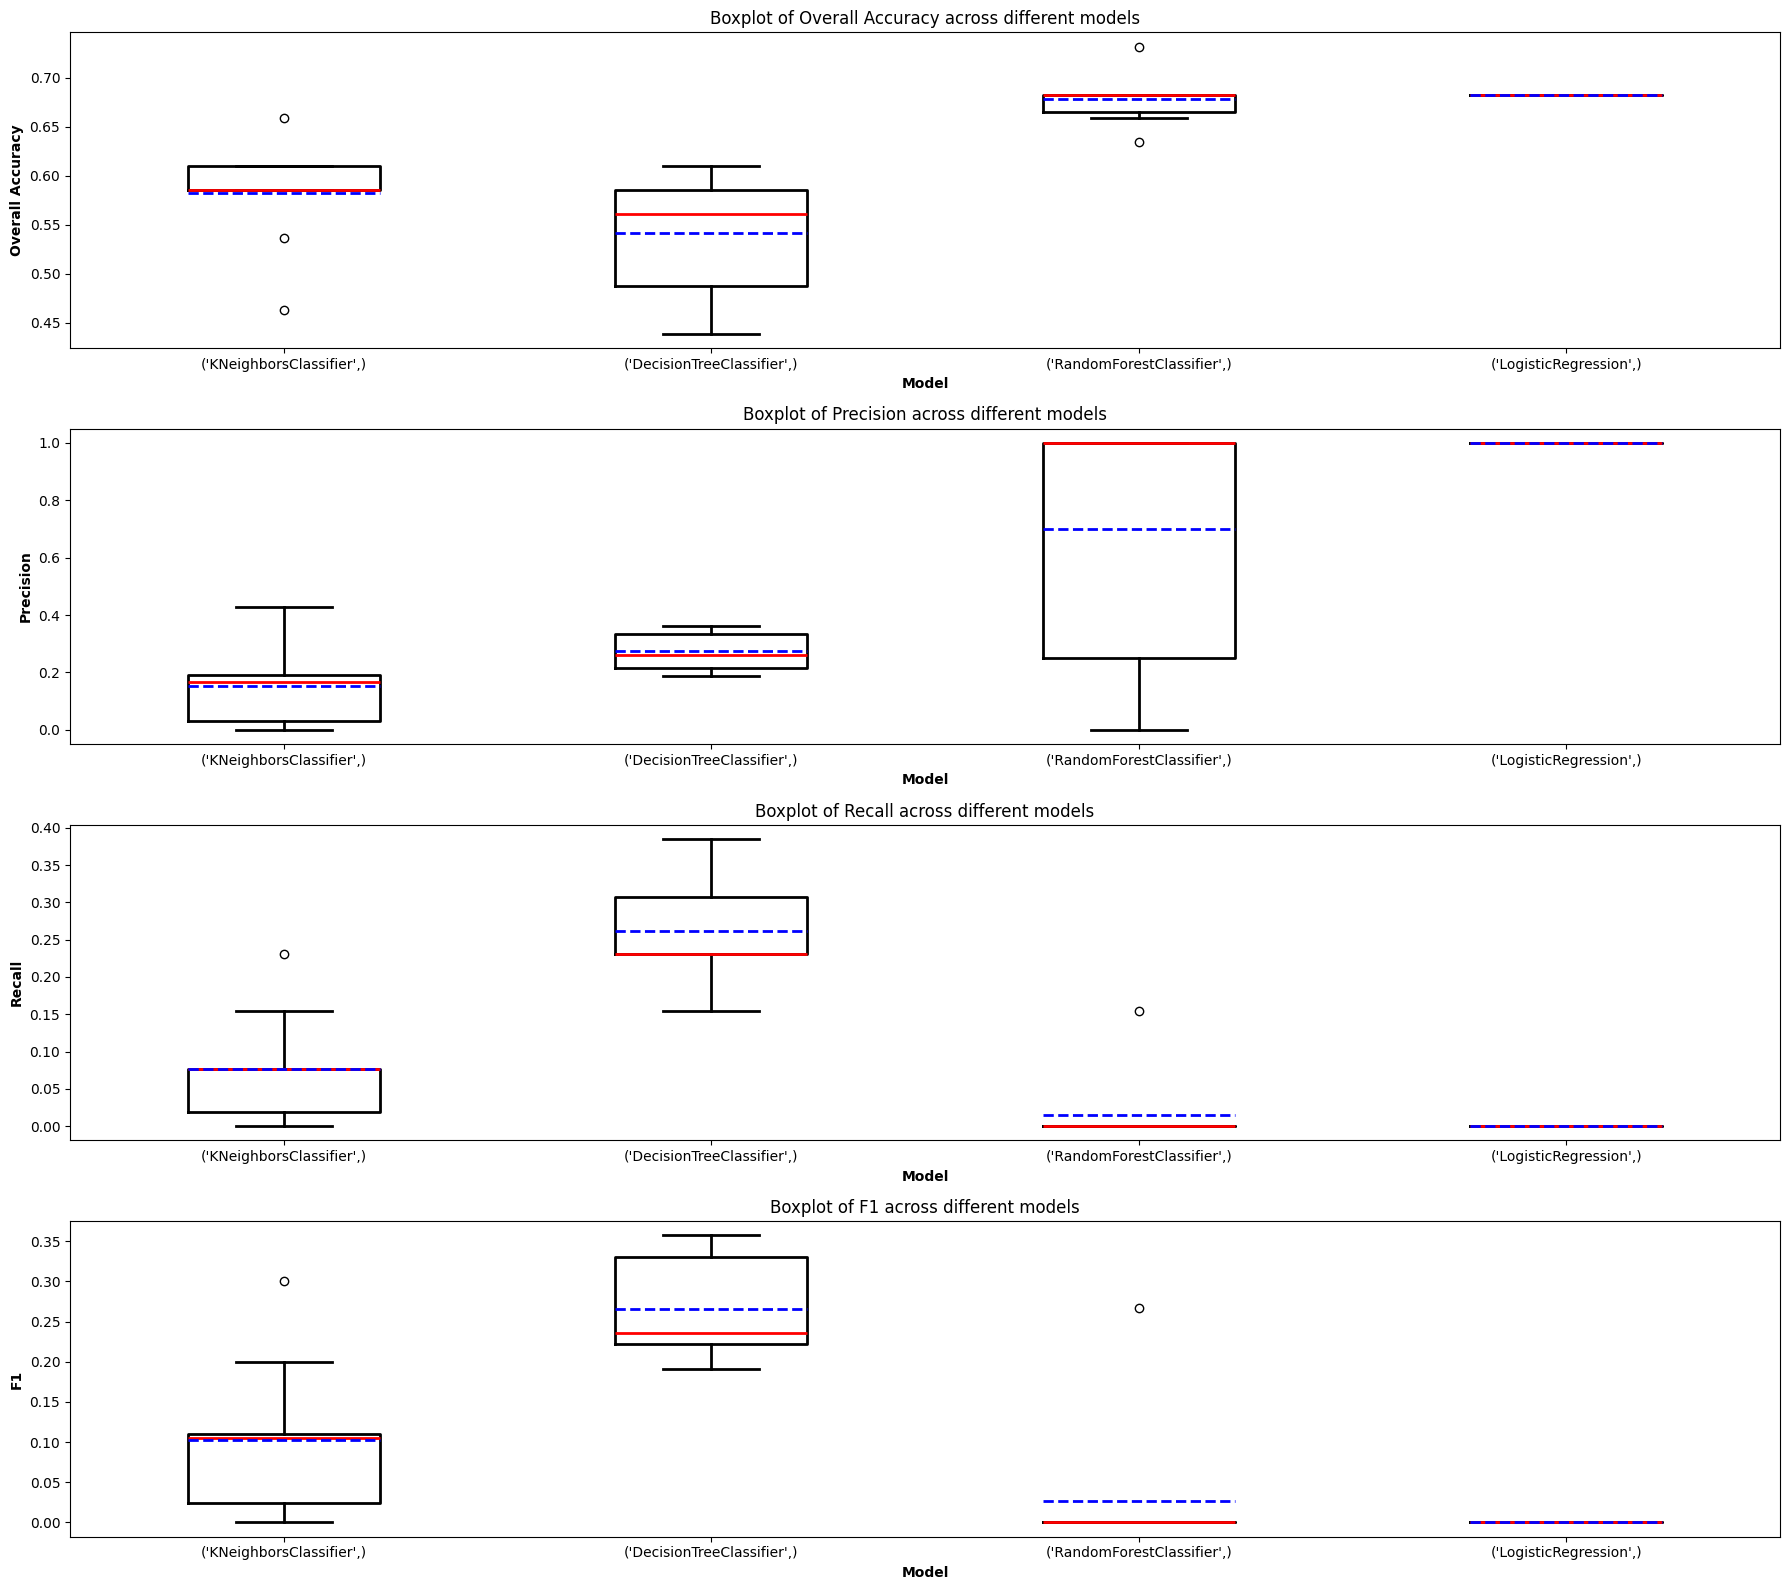

In [63]:
plot_metrics(s_metrics, ["Overall Accuracy", "Precision", "Recall", "F1"])

In [64]:
f_metrics, f_train = evaluate(friends_models, friends_dataset, "friends",1)

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


In [ ]:
plot_metrics(f_metrics, ["Overall Accuracy", "Precision", "Recall", "F1"])

In [ ]:
c_metrics, c_train = evaluate(cancer_models, cancer_dataset, "cancer", 2)

In [ ]:
plot_metrics(c_metrics, ["Overall Accuracy", "Precision", "Recall", "F1"])